# HOMEWORK

The goal of this homework is to create a regression model for predicting housing prices (column `median_house_value`).

In this homework we'll again use the `California Housing Prices` dataset

## LIBRARIES

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

/Users/premsurawut/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## DATASET

In [2]:
from pathlib import Path

data_path = Path('./dataset/')
data_path.mkdir(parents=True, exist_ok=True)

if Path.is_file(Path('./dataset/housing.csv')):
    print('File exists')
else:
    !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
    !mv housing.csv ./dataset/housing.csv

File exists


In [3]:
dataset_path = './dataset/housing.csv'

- Apply the log transform to `median_house_value`
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state` parameter to 1.
- Use `DictVectorizer` to turn train and validation into metrics.

## Prepare dataset

- feature extraction
- cleansing data

In [4]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]

df = pd.read_csv(dataset_path, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

## Split dataset

- train dataset
- validation dataset
- test dataset
- shuffle dataset
- random state

In [5]:
# df.median_house_value = df.median_house_value.values
df.median_house_value = np.log1p(df.median_house_value)
df_full_train, df_test = train_test_split(df, test_size=.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=1)

In [6]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Prepare feature for model training

In [7]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)
x_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regresson to predict the `median_house_value` variable. 

Train model with `max_depth=1`

In [8]:
# DecisionTree regressor training

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(x_val)
mse = mean_squared_error(y_pred, y_val)
mse

0.2188716880874183

In [9]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/premsurawut/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs1 (optional - to make training faster)

In [10]:
# from sklearn.metrics import rmse
n_estimators = 10
random_state = 1
n_jobs = -1

rf = RandomForestRegressor(n_estimators=n_estimators, 
                           random_state=random_state,
                          n_jobs=n_jobs)
rf.fit(X_train, y_train)
y_pred = rf.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.24579193759466625

## Question 3

Now, let's experiment with `n_estimators` parameters.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1
- Evaluate the model on the validation dataset.


In [18]:
scores = []

for n in tqdm(range(10, 201, 10)):
    
    rf = RandomForestRegressor(n_estimators=n,
                              random_state=random_state,
                              n_jobs=n_jobs)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(x_val)
    rmse_score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, round(rmse_score, 3)))

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
df_rf_score = pd.DataFrame(scores, columns=['n_estimators', 'rmse_score'])
df_rf_score.sort_values(by=['rmse_score'])

,n_estimators,rmse_score
10,110,0.231
9,100,0.232
17,180,0.232
16,170,0.232
15,160,0.232
14,150,0.232
13,140,0.232
12,130,0.232
11,120,0.232
19,200,0.232


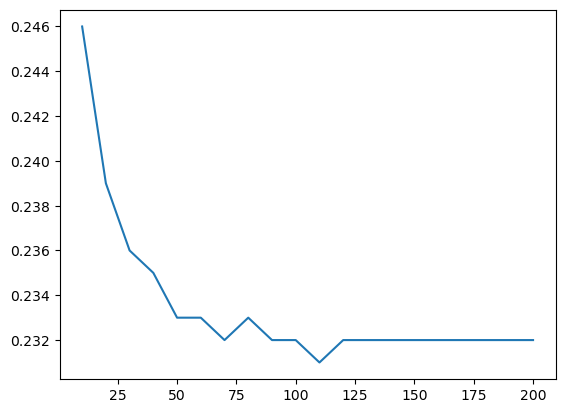

In [20]:
plt.plot(df_rf_score.n_estimators, df_rf_score.rmse_score)

## Question 4

Let's select the best `max_depth`:

- Try different values of `max_depth`: `[10, 15, 20, 25]
- For each of theses values, try different values of `n_estimators` from 10 till 200 (with step 10)
- Fix the random seed: `random_state=1`

In [28]:
scores = []
max_depths = [10, 15, 20, 25]

for d in tqdm(max_depths):
    for n in tqdm(range(10, 201, 10)):
        
        rf = RandomForestRegressor(max_depth=d,
                                  n_estimators=n,
                                  random_state=random_state
                                  )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(x_val)
        rmse_score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, rmse_score))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
columns = ['max_depths', 'n_estimators', 'rmse_score']        
df_rf_score2 = pd.DataFrame(scores, columns=columns)

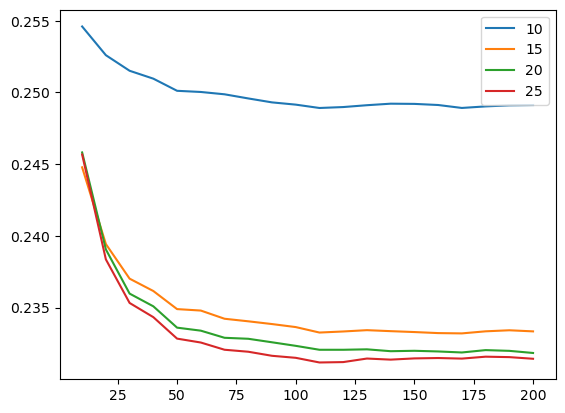

In [33]:
for d in max_depths:
    df_subset = df_rf_score2[df_rf_score2.max_depths == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse_score, label=d)
plt.legend()    

## Quest 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_ field`.

For this homework question, we'll find the most important feature:

- Train the model with these parametes:
    - `n_estimators=10`,
    - `max_depth=20`,
    - `random_state=1`,
    - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the most important feature?

- `total_rooms`
- `median_income`
- `total_bedrooms`
- `longitude`

In [39]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

df_importance = pd.DataFrame()
df_importance['feature_importance'] = dv.get_feature_names()
df_importance['importance_score'] = rf.feature_importances_
df_importance.sort_values(by=['importance_score'], ascending=False)

/Users/premsurawut/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature_importance,importance_score
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333
3,longitude,0.096341
1,housing_median_age,0.033197
10,population,0.030999
12,total_rooms,0.020465
11,total_bedrooms,0.019373
0,households,0.016141
9,ocean_proximity=NEAR OCEAN,0.004452


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

In [81]:
features = dv.get_feature_names()
features_name = []

for f in features:
    f_new = f.replace('<', '')
    features_name.append(f_new)
    
features_name

/Users/premsurawut/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [82]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_name)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features_name)

In [92]:
%%capture output_eta1

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [93]:
%%capture output_eta2

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [101]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

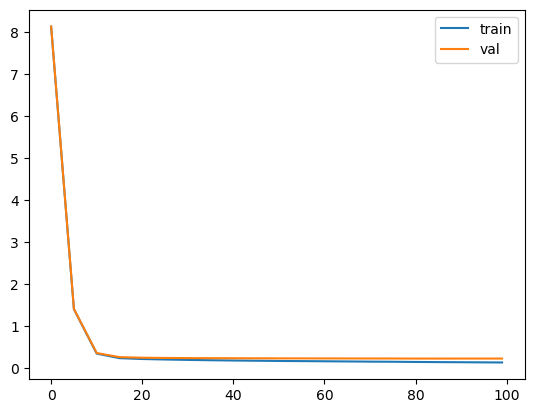

In [107]:
eta_03 = parse_xgb_output(output_eta1)
plt.plot(eta_03.num_iter, eta_03.train_rmse, label='train')
plt.plot(eta_03.num_iter, eta_03.val_rmse, label='val')
plt.legend()

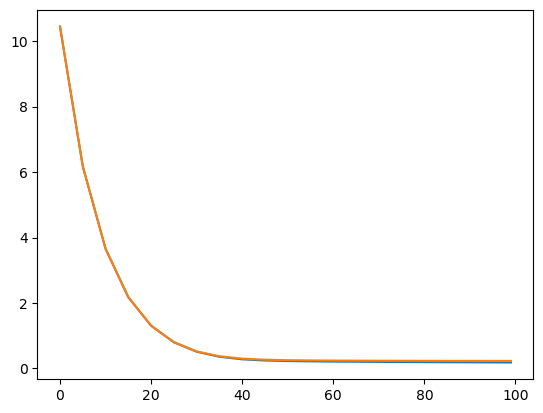

In [108]:
eta_01 = parse_xgb_output(output_eta2)
plt.plot(eta_01.num_iter, eta_01.train_rmse, label='train')
plt.plot(eta_01.num_iter, eta_01.val_rmse, label='val')

In [123]:
from IPython.display import display

display(eta_03.head(1).sort_values(by='val_rmse', ascending=True))
display(eta_01.head(1).sort_values(by='val_rmse', ascending=True))

,num_iter,train_rmse,val_rmse
0,0,8.12733,8.13245


,num_iter,train_rmse,val_rmse
0,0,10.44371,10.44938
